Потрібно створити кілька моделей класифікації (логістична регресія, svm, k-mean, NBC, 
Decision Tree and Random Forest) для порівняння результатів.
Для того, щоб можна було порівнювати ваші результати, зробіть крос-валідацію на 4 фолди.
Підберіть параметри так, щоб отримати найкращі результати.

Про набір даних.
Цей набір даних отримано від Національного інституту діабету, захворювань органів травлення та нирок. Мета полягає в тому, щоб передбачити на основі діагностичних вимірювань, чи є у пацієнта діабет.

Кількість спостережень: 768
Кількість атрибутів: 8 плюс клас
Для кожного атрибута: (усі мають числові значення)
1. Кількість разів вагітності
2. Концентрація глюкози в плазмі через 2 години в оральному тесті на толерантність до глюкози
3. Діастолічний артеріальний тиск (мм рт. ст.)
4. Товщина шкірної складки трицепса (мм)
5. 2-годинний сироватковий інсулін (мкОд/мл)
6. Індекс маси тіла (вага в кг/(зріст у м)^2)
7. Діабет племінна функція
8. Вік (років)
9. Змінна класу (0 або 1)

In [947]:
import pandas as pd
diabetes_data = pd.read_csv('./diabetes.csv', sep=',', header=0)

# перевірити чи є пропущені дані
print('Кількість спостережень:', len(diabetes_data))
diabetes_data.dropna()
print('Кількість спостережень з цілісними даними:', len(diabetes_data))
diabetes_data


Кількість спостережень: 768
Кількість спостережень з цілісними даними: 768


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


In [948]:
# 1. Логістична регресія
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold

X = diabetes_data[['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']]

y = diabetes_data['Outcome'].values

# ініціалізуємо об'єкт класу, яким користуватимемося для розбивки даних
kf = KFold(
    n_splits=4,  # кількість окремих тестових наборів
    shuffle=True,  # чи перемішувати дані перед тим, як розділити на окремі фрагменти
    random_state=42  # фіксація випадкового стану
)
 

In [949]:
from sklearn.inspection import permutation_importance
def calculate_importance(mdl, X_test, y_test):
    test_res = [], [], []
    importances = permutation_importance(
        mdl, X_test, y_test,  # модель та дані, на яких оцінювати важливість
        n_repeats=10,  # скільки разів повторити перемішування та оцінку важливості
        random_state=42  # фіксація випадкового стану
        )
        
    for i, column in enumerate(X_test.columns):    
        # вивести на екран ім'я змінної, середнє значення та стандартне відхилення важливості змінної
        print(column, importances.importances_mean[i], importances.importances_std[i])

In [950]:
# отримуємо відсоток хибнопозитивних та хибнонегативних прикладів для різних порогових значень
from matplotlib import pyplot as plt
import numpy as np
from sklearn.metrics import auc, roc_curve

def get_roc_curve(y_test, test_preds):
    test_fpr, test_tpr, _ = roc_curve(y_test, test_preds)

    # обчислимо значення AUC для тестового наборів
    test_auc = np.round(auc(test_fpr, test_tpr), 4)

    # побудуємо графік RUC кривою для обох наборів даних
    # plt.subplots(2, 5, figsize=(15, 6))
    plt.plot(test_fpr, test_tpr, label=f'AUC на тестовому наборі: {test_auc}')
    plt.legend()  # додамо легенду, щоб відобразилися значення параметрів "label" у кожному графіку
    plt.show()

In [951]:
# Бачимо, що показники SkinThickness, Insulin, Age не відіграють важливої ролі для передбачення. Тому ми їх видаляємо, щоб зробити модель чіткішою.
#diabetes_data.drop(['SkinThickness', 'Insulin', 'Age'], axis=1, inplace=True)
#diabetes_data
X = diabetes_data[['Pregnancies', 'Glucose', 'BloodPressure', 'BMI', 'DiabetesPedigreeFunction']]


In [952]:
import numpy as np
from mlxtend.plotting import plot_decision_regions


# створюємо список моделей 
modelsList = { }

# перевіряємо метрики моделей для кожної моделі в списку
def evaluate_model(val, **mdl):
  # ініціалізуємо порожній список, в який зберігатимемо значення кривої на кожному фолді
  #test_res_y, test_res_y_pred = [], []

  for modelName, model in mdl.items():
    # отримаємо індекси навчального та тестового набору
    for train_idx, test_idx in kf.split(X, y):
      # виберемо поточну навчальну та тестову групи
      X_train, y_train = X.loc[train_idx], y[train_idx]
      X_test, y_test = X.loc[test_idx], y[test_idx]  
      
      # навчимо модель
      model.fit(X_train, y_train)
      
      # виберемо прогнози
      y_test_preds = model.predict(X_test)
     
      # порахуємо середнє значення та збережемо у список 
      y_test_r = np.round(y_test)
      #test_res_y.append(new_value)
      y_test_pred_r = np.round(y_test_preds)
      #test_res_y_pred.append(new_value_pred)
      avg_prd_val = np.mean(model.predict(val))

    # виведемо прогнози для заданого значення
    print(f'Передбачення з використанням моделі {modelName}:', avg_prd_val)
    print(f'Площа ROC кривої тестового набору моделі {modelName}')
    get_roc_curve(y_test_r, y_test_pred_r)
     
    

In [953]:
# ініціалізація Logistic Regression моделі 
from sklearn.linear_model import LogisticRegression


logRegMdl = LogisticRegression()

# додаємо модель до списку
modelsList['Logistic Regression'] = logRegMdl

In [954]:
# ініціалізація SVM моделі 
from sklearn.svm import SVC

svc = SVC(
    C=1.,  # значення константи регулярізації з формули вище: чим більше, тим слабше регулярізація
    kernel='rbf'
    )

# додаємо модель до списку
modelsList['Support Vector Machine'] = svc

In [955]:
# ініціалізація k-mean моделі 
from sklearn.cluster import KMeans

km = KMeans(
    n_clusters=3,  # кількість кластерів
    n_init=10,  # кількість спроб ініціалізації
    random_state=42  # фіксація випадкового стану
)

# додаємо модель до списку
modelsList['K-mean'] = km

In [956]:
# ініціалізація k-NBC моделі
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()

# додаємо модель до списку
modelsList['Naive Bayes Classifier'] = gnb

In [957]:
# ініціалізація Decision Tree моделі
from sklearn.tree import DecisionTreeClassifier

treeMdl = DecisionTreeClassifier(
    criterion='gini',  # критерій розбивки gini дає кращі результати ніж entropy
    splitter='random',
    max_depth=2,  # максимальна кількість розбиттів (глибина дерева)
    min_samples_split=2,  # мінімальна кількість спостережень, щоб зробити розбиття
    min_samples_leaf=2,  # мінімальна кількість спостережень, щоб сформувати лист дерева
    max_features=2
)

modelsList['Decision Tree'] = treeMdl

In [958]:
# ініціалізація Random Forest моделі
from sklearn.ensemble import RandomForestClassifier

forestMdl = RandomForestClassifier(
    n_estimators = 80, # кількість дерев, які потрібно побудувати
    criterion='gini', # критерій побудови: підвищення однорідності у листі дерева
    max_depth=3, # максимальна глибина дерева
    min_samples_split=10, # мінімальна кількість спостережень, щоб зробити розбивку даних на 2 підгрупи
    min_samples_leaf=2, # мінімальна кількість спостережень, яка може сформувати лист дерева
    max_features=0.8, # максимальна кількість змінних, якими можна скористатися в одному дереві
    bootstrap=True, # чи будувати кожне дерево на вибірці з оригінальних даних
    max_samples=0.8, # частка даних, яка може бути використана в побудові одного дерева
    random_state=42 # фіксація випадкового стану
)

modelsList['Random Forest'] = forestMdl

Передбачення з використанням моделі Logistic Regression: 0.0
Площа ROC кривої тестового набору моделі Logistic Regression


/opt/homebrew/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


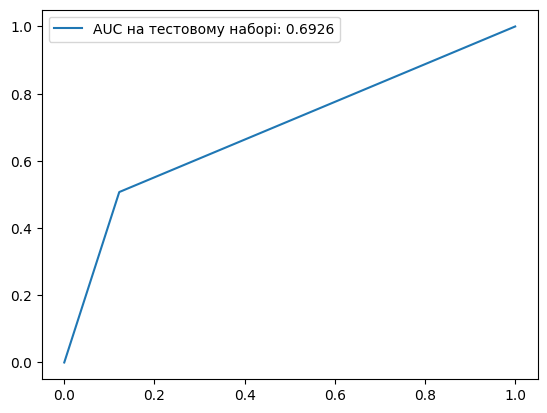

Передбачення з використанням моделі Support Vector Machine: 0.0
Площа ROC кривої тестового набору моделі Support Vector Machine


/opt/homebrew/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


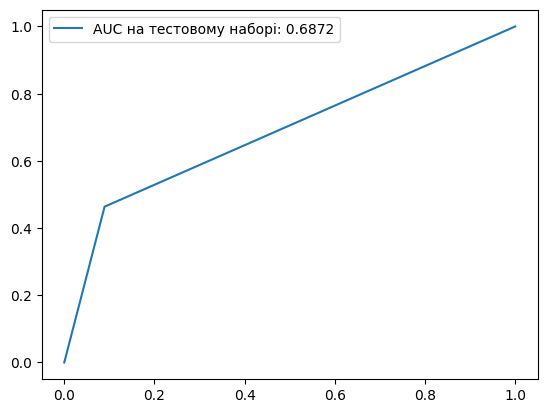

/opt/homebrew/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


Передбачення з використанням моделі K-mean: 1.0
Площа ROC кривої тестового набору моделі K-mean


/opt/homebrew/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


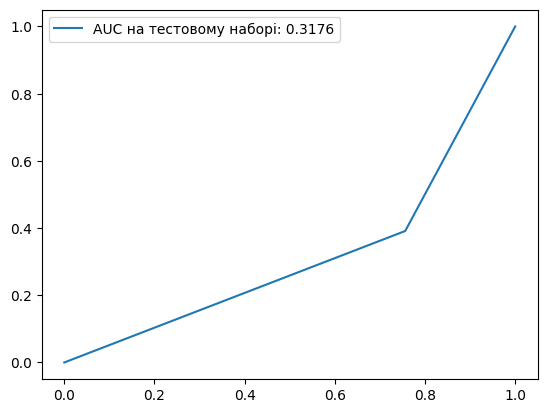

Передбачення з використанням моделі Naive Bayes Classifier: 0.0
Площа ROC кривої тестового набору моделі Naive Bayes Classifier


/opt/homebrew/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but GaussianNB was fitted with feature names
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but GaussianNB was fitted with feature names
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but GaussianNB was fitted with feature names
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but GaussianNB was fitted with feature names
  warnings.warn(


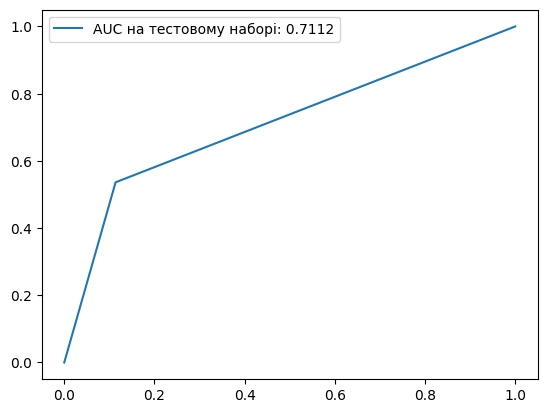

/opt/homebrew/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


Передбачення з використанням моделі Decision Tree: 0.0
Площа ROC кривої тестового набору моделі Decision Tree


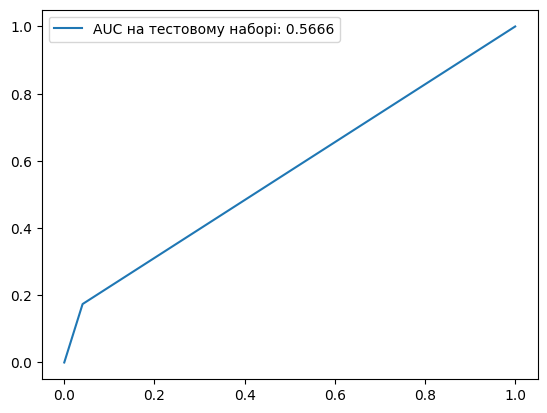

/opt/homebrew/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Передбачення з використанням моделі Random Forest: 0.0
Площа ROC кривої тестового набору моделі Random Forest


/opt/homebrew/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


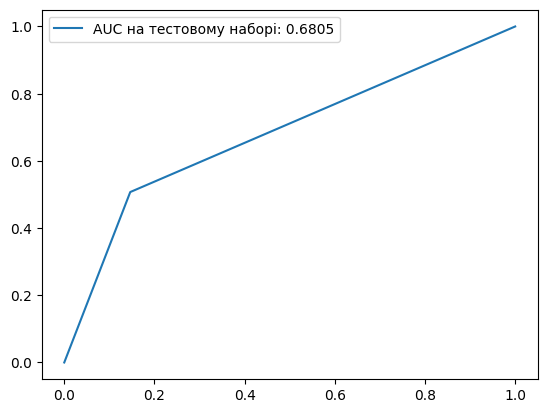

In [959]:
test = [[1, 126, 60, 30, 0.35]]
		
evaluate_model(test, **modelsList)

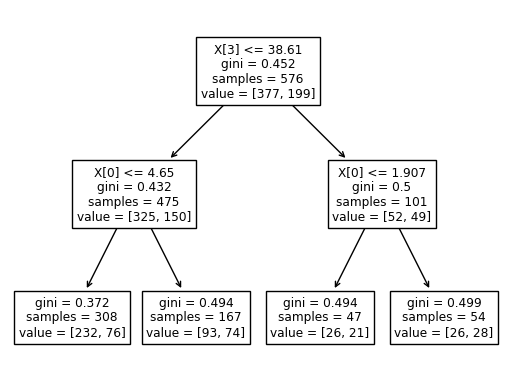

In [960]:
from sklearn.tree import plot_tree

# будуємо дерево 
plot_tree(treeMdl)
plt.show()